# Binary Image Classification using LeNet-5 on MNIST (Even vs Odd)

In [ ]:
!pip install torch torchvision matplotlib scikit-learn seaborn --quiet

### Import Required Libraries
- PyTorch core and neural network modules are imported.
- Torchvision for MNIST dataset and transformations.
- Scikit-learn for confusion matrix and classification report.
- Matplotlib/Seaborn for visualization.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Define Transformations
- Normalize MNIST pixel values using `ToTensor()` which scales them to [0,1].


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

### Load and Modify MNIST Dataset (Even vs Odd)
- A custom dataset wrapper converts 10-class MNIST into binary classification:
- Even digits (0, 2, 4, 6, 8) → 0
- Odd digits (1, 3, 5, 7, 9) → 1


In [4]:
class BinaryMNIST(Dataset):
    def __init__(self, train=True):
        self.data = torchvision.datasets.MNIST(root="./data", train=train, download=True, transform=transform)
        self.binary_labels = torch.tensor([(label % 2 != 0) for label in self.data.targets], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, _ = self.data[idx]
        label = self.binary_labels[idx]
        return image, label

In [ ]:
train_dataset = BinaryMNIST(train=True)
test_dataset = BinaryMNIST(train=False)

### Create DataLoaders
- Data is loaded in batches for efficient training and testing using DataLoader.
- Shuffling is applied to training data to ensure better generalization.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Define the LeNet-5 Architecture
- LeNet-5 consists of:
- Conv1: 6 filters, 5x5 kernel, padding=2 → ReLU → AvgPool
- Conv2: 16 filters, 5x5 kernel → ReLU → AvgPool
- Flatten → Fully Connected: 120 → 84 → 1 output neuron
- Sigmoid activation for binary classification

In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### Initialize Model, Loss, and Optimizer
- Model is transferred to GPU (if available).
- Binary Cross Entropy Loss is used since the output is a single sigmoid neuron.
- Adam optimizer is used for faster convergence.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the Model
- For each epoch:
  - Zero the gradients
  - Perform forward pass
  - Compute loss
  - Backward pass and optimizer step
- Average loss per epoch is printed.

In [9]:
from tqdm import tqdm

for epoch in range(10):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1777


Epoch 2, Loss: 0.0652


Epoch 3, Loss: 0.0452


Epoch 4, Loss: 0.0363


Epoch 5, Loss: 0.0306


Epoch 6, Loss: 0.0252


Epoch 7, Loss: 0.0221


Epoch 8, Loss: 0.0188


Epoch 9, Loss: 0.0160


Epoch 10, Loss: 0.0148


### Evaluate the Model
- Model is set to eval mode to disable dropout/batch norm.
- Predictions are thresholded at 0.5 to get binary output.
- Actual and predicted labels are collected for metrics.

In [10]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating", leave=True):
        images = images.to(device)
        outputs = model(images)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        y_pred.extend(preds.flatten())
        y_true.extend(labels.numpy().flatten())

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.18it/s]


### Plot the Confusion Matrix
- Displays the count of true vs. predicted labels in a heatmap.

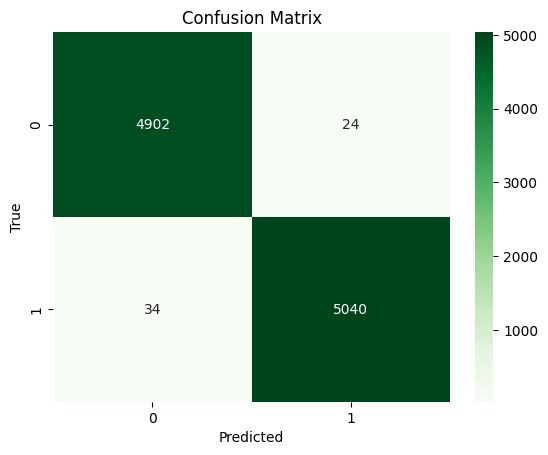

In [11]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Generate the Classification Report
- Prints precision, recall, F1-score, and support for both classes.

In [12]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4926
         1.0       1.00      0.99      0.99      5074

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

